# Week 3 Kaggle Project: Histopathologic Cancer Detection

## Step 1: Intro

### Problem
For the histopathic cancer detection project the challenge is to classify small image patches extracted from larger scans as containing metastatic cancer tissue or not. This is a binary classification problem and will be solved implementing deep learning approaches. 

### Data
Input Data: Image patches.

    Each patch contains 32x32 pixels with RGB channels.
    The central region (32x32px) is relevant for the label, while the outer parts may contain unrelated information.

Output: Binary classification (0 for no tumor, 1 for tumor presence).

Size and Structure:

    Dataset contains thousands of images.
    Images are small (32x32 pixels) and computationally manageable.

In [13]:
#import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [14]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

## Step 2: Exploratory Data Analysis (EDA) 

Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [21]:
#load and describe the data
data_dir = '/Users/adrienne/Desktop/Week3_Cancer_Kaggle'  
train_labels = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
train_images_dir = os.path.join(data_dir, 'train')
val_images_dir = os.path.join(data_dir, 'val')
test_images_dir = os.path.join(data_dir, 'test')

In [22]:
#check data structure
print("Number of training samples:", len(train_labels))
print("Sample training data:")
print(train_labels.head())

Number of training samples: 220025
Sample training data:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


There are 22025 training samples with an ID and a label.

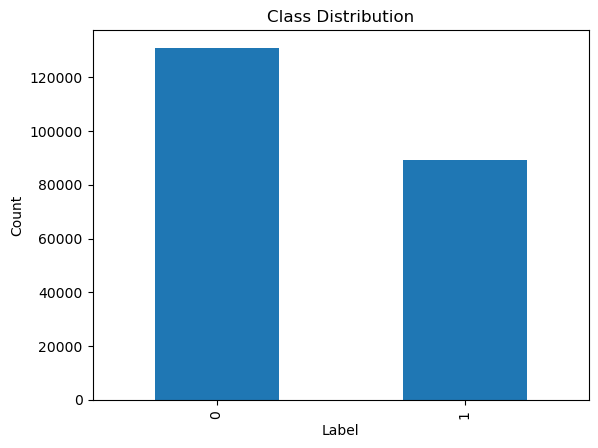

In [23]:
#check class distribution
train_labels['label'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

There are over 120,000 samples without a tumor present (0) and just over 80,000 with a tumor present (1). 

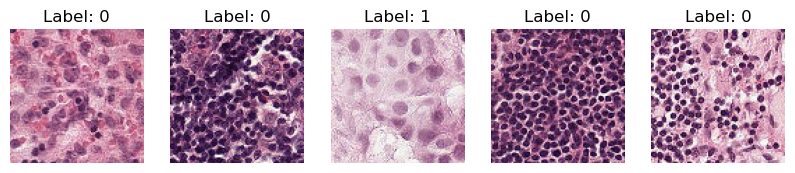

In [24]:
#visualizing samples
sample_images = train_labels.sample(5)
plt.figure(figsize=(10, 10))
for i, row in enumerate(sample_images.itertuples()):
    img_path = os.path.join(train_images_dir, row.id + '.tif')
    img = cv2.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Label: {row.label}")
    plt.axis('off')
plt.show()

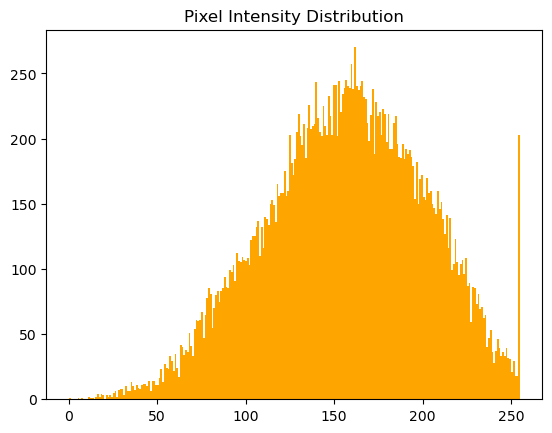

In [25]:
#pixel intensity distribution
img_sample = cv2.imread(os.path.join(train_images_dir, sample_images.iloc[0].id + '.tif'))
plt.hist(img_sample.ravel(), bins=256, color='orange', )
plt.title('Pixel Intensity Distribution')
plt.show()

Normalize the pizel values to standardize input range to ensure all features contribute equally to model's computation. Model will also perform better and converge faster. It also helps avoid potential instability. This step ensures both augmented and original images have the same pixel value range, maintaining uniformity in the training pipeline.

In [29]:
#add paths to DataFrame for generators
train_labels['image_path'] = train_labels['id'].apply(lambda x: os.path.join(train_images_dir, f"{x}.tif"))
#convert label column to string
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)


In [30]:
#generator specifications
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [31]:
#train generator
train_generator = train_datagen.flow_from_dataframe(
    train_labels,
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 176020 validated image filenames belonging to 2 classes.


In [32]:
#vlidation generator
val_generator = val_datagen.flow_from_dataframe(
    val_labels,
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 44005 validated image filenames belonging to 2 classes.


In [33]:
#test generator
#replace df_test with appropriate test DataFrame if needed
test_generator = test_datagen.flow_from_dataframe(
    dataframe=val_labels,  #replace with test data if available
    x_col='image_path',
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 44005 validated image filenames.


## Step 3: DModel Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

We will begin with a Convolutional Neural Network (CNN), as image data requires spatial feature extraction.
We will then fine tune the hyperparameters of this model for comparison. Finally, we will use a transfer learning model to compare, as well.

## Model 1: CNN Baseline Architecture

Input Layer:

    Input Shape: (96, 96, 3) to process 96x96 RGB images.

Convolutional Layers and Max Pooling:

    Conv2D (32 filters): Applies 32 filters of size (3x3) with ReLU activation to extract low-level features such as edges and corners.
    MaxPooling2D (2x2): Reduces the spatial dimensions (height and width) by half, retaining important features while reducing computation.
    Conv2D (64 filters): Adds 64 filters of size (3x3) for higher-level feature extraction.
    MaxPooling2D (2x2): Further reduces spatial dimensions, focusing on essential features.
    Conv2D (128 filters): Applies 128 filters of size (3x3) to extract even more complex features.
    MaxPooling2D (2x2): Reduces spatial dimensions once again.

Flattening Layer:

    Flatten: Converts the 3D feature maps into a 1D vector to feed into the fully connected layer.

Dense Layers:

    Dense (128 units): Fully connected layer with 128 neurons and ReLU activation to learn patterns from the extracted features.
    Dropout (50%): Randomly disables 50% of neurons during training to prevent overfitting.

Output Layer:

    Dense (1 unit): Final dense layer with 1 neuron and sigmoid activation for binary classification (cancer vs. non-cancer).

Loss Function:

    Binary Crossentropy: Suitable for binary classification problems.

Optimizer:

    Adam Optimizer: Adjusts learning rates dynamically for efficient convergence.

In [34]:
#define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

/Users/adrienne/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
#debugging train generator output
# for batch_images, batch_labels in train_generator:
#     print(f"Train batch images shape: {batch_images.shape}")  #should be (32, 96, 96, 3)
#     print(f"Train batch labels shape: {batch_labels.shape}")  #should be (32,)
#     print(f"First batch sample pixel range: {batch_images[0].min()} to {batch_images[0].max()}")
#     break

# #debugging validation generator output
# for batch_images, batch_labels in val_generator:
#     print(f"Validation batch images shape: {batch_images.shape}")  #should be (32, 96, 96, 3)
#     print(f"Validation batch labels shape: {batch_labels.shape}")  #should be (32,)
#     break

Train batch images shape: (32, 96, 96, 3)
Train batch labels shape: (32,)
First batch sample pixel range: 0.10588236153125763 to 1.0
Validation batch images shape: (32, 96, 96, 3)
Validation batch labels shape: (32,)


In [35]:
#compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
#model training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/Users/adrienne/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 585s 106ms/step - accuracy: 0.7803 - loss: 0.4823 - val_accuracy: 0.8447 - val_loss: 0.3490
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 545s 99ms/step - accuracy: 0.8575 - loss: 0.3444 - val_accuracy: 0.8782 - val_loss: 0.2862
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 543s 99ms/step - accuracy: 0.8780 - loss: 0.3034 - val_accuracy: 0.8688 - val_loss: 0.3010
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 539s 98ms/step - accuracy: 0.8870 - loss: 0.2801 - val_accuracy: 0.8974 - val_loss: 0.2538
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 549s 100ms/step - accuracy: 0.8914 - loss: 0.2731 - val_accuracy: 0.8878 - val_loss: 0.2900
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 555s 101ms/step - accuracy: 0.8986 - loss: 0.2600 - val_accuracy: 0.9111 - val_loss: 0.2304
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 543s 99ms/step - accuracy: 0.9040 - loss: 0.2469 - val_accuracy: 0.9084 - val_loss: 0.2323
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 560s 102ms/step - accura

In [37]:
model.save('model1.h5')

#save the trained model
model_save_path = os.path.join(data_dir, 'histopathologic_cancer_model.h5')
model.save(model_save_path)
print('Model saved to: ', model_save_path)

Model saved to:  /Users/adrienne/Desktop/Week3_Cancer_Kaggle/histopathologic_cancer_model.h5


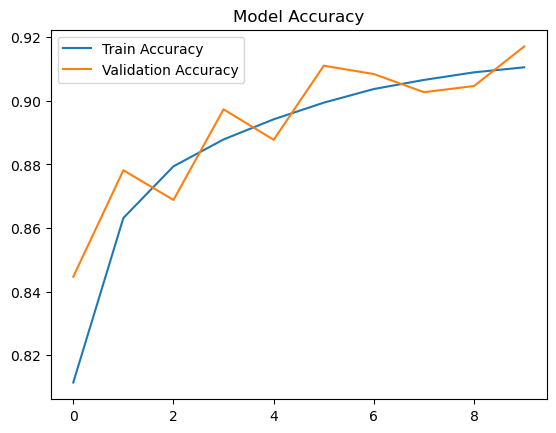

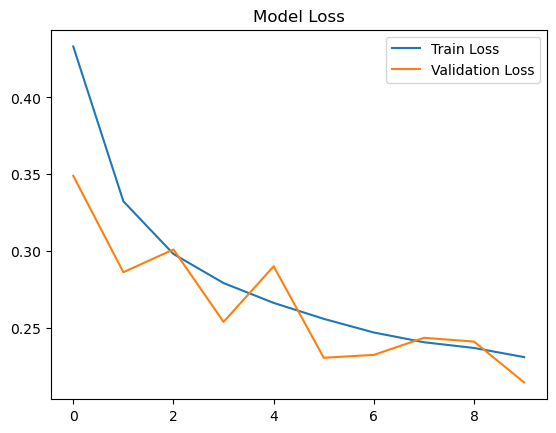

In [38]:
#plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

#### Observations:
Accuracies: The training accuracy steadily increases, indicating that the model is learning the training data. The validation accuracy follows a similar trend but plateaus. There is no significant divergence between the two accuracies which is a good sign that there is minimal overfitting.

Loss: Training loss decreases steadily, showing that the model is optimizing on the training data. Validation loss fluctuates a little bit but follows a downward trend. The gap between the two loses is small which indicates minimal overfitting. 

In [44]:
#evaluate on Test Set
#manually preprocess test images before prediction
test_filenames = test_generator.filenames
test_images = []

for file in test_filenames:
    img_path = os.path.join(test_images_dir, file)
    img = plt.imread(img_path)
    img = np.clip(img, 0, 255) / 255.0  #clip to [0, 255] and normalize to [0, 1]
    img_resized = tf.image.resize(img, (96, 96))  #resize to (96, 96)
    test_images.append(img_resized)

test_images = np.stack(test_images, axis=0)  #create a batch
print(f"Test images shape: {test_images.shape}")

#predict
test_predictions = model.predict(test_images)

Test images shape: (44005, 96, 96, 3)
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step


In [48]:
test_files = os.listdir(test_images_dir)
test_images = []

#load and preprocess test images
for file in test_files:
    img_path = os.path.join(test_images_dir, file)
    img = plt.imread(img_path)  #load image
    img = img / 255.0  #normalize pixel values to [0, 1]
    img_resized = tf.image.resize(img, (96, 96))  #resize to (96, 96)
    test_images.append(img_resized)

#convert to numpy array
test_images = np.stack(test_images, axis=0)
print(f"Test images shape: {test_images.shape}")




Test images shape: (57458, 96, 96, 3)


In [49]:
#predict using the preprocessed test images
test_predictions = model.predict(test_images)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step


In [50]:
submission = pd.DataFrame({
    'id': [os.path.splitext(file)[0] for file in test_files],
    'label': test_predictions.flatten()
})

#save submission file
submission_file_path = os.path.join(data_dir, 'submission.csv')
submission.to_csv(submission_file_path, index=False)
print(f"Submission file saved to {submission_file_path}")


Submission file saved to /Users/adrienne/Desktop/Week3_Cancer_Kaggle/submission.csv


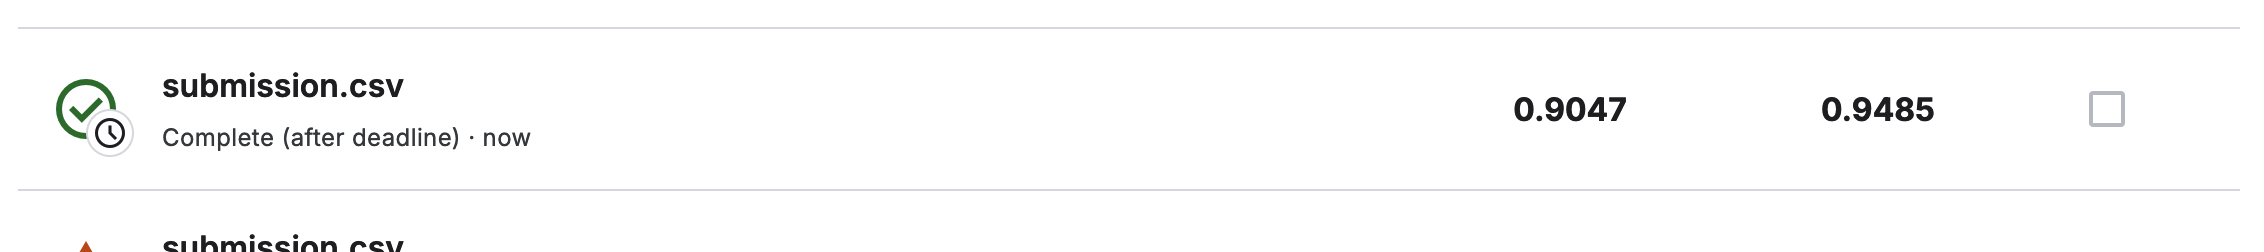

## Model 2: Hyperparameter Tuning on CNN Model

The accuracies and loss in the first model were good but could likely be improved with parameter tuning. In this section we will perform this.

In [52]:
from keras_tuner import Hyperband

#define the model-building function for KerasTuner
def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Choice('conv_1_filters', values=[32, 64, 128], default=64),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(96, 96, 3)
        ),
        MaxPooling2D((2, 2)),
        
        Conv2D(
            filters=hp.Choice('conv_2_filters', values=[64, 128, 256], default=128),
            kernel_size=(3, 3),
            activation='relu'
        ),
        MaxPooling2D((2, 2)),
        
        Conv2D(
            filters=hp.Choice('conv_3_filters', values=[128, 256, 512], default=256),
            kernel_size=(3, 3),
            activation='relu'
        ),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(
            units=hp.Int('dense_units', min_value=64, max_value=256, step=64, default=128),
            activation='relu'
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1, default=0.3)),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3)
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model




In [56]:
#initialize the KerasTuner
from keras_tuner import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Limit to 10 trials
    directory='tuning_logs',
    project_name='histopathologic_cancer'
)

#best hyperparameters search
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
)

#best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of filters in the first conv layer is {best_hps.get('conv_1_filters')}.\n
The optimal number of filters in the second conv layer is {best_hps.get('conv_2_filters')}.\n
The optimal dropout rate is {best_hps.get('dropout_rate')}.\n
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Reloading Tuner from tuning_logs/histopathologic_cancer/tuner0.json

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
64                |32                |conv_1_filters
256               |64                |conv_2_filters
512               |256               |conv_3_filters
64                |192               |dense_units
0.3               |0.3               |dropout_rate
0.01              |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 787/5501 ━━━━━━━━━━━━━━━━━━━━ 50:03 637ms/step - accuracy: 0.5838 - loss: 4.6965

KeyboardInterrupt: 

In [57]:

#get the best hyperparameters from completed trials
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first conv layer is {best_hps.get('conv_1_filters')}.\n
The optimal number of filters in the second conv layer is {best_hps.get('conv_2_filters')}.\n
The optimal dropout rate is {best_hps.get('dropout_rate')}.\n
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

Reloading Tuner from tuning_logs/histopathologic_cancer/tuner0.json

The optimal number of filters in the first conv layer is 32.

The optimal number of filters in the second conv layer is 64.

The optimal dropout rate is 0.30000000000000004.

The optimal learning rate is 0.001.



In [58]:
#build the best model and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

#save the best model
best_model.save(os.path.join(data_dir, 'best_histopathologic_cancer_model.h5'))

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 761s 138ms/step - accuracy: 0.7879 - loss: 0.4604 - val_accuracy: 0.8707 - val_loss: 0.3087
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 850s 154ms/step - accuracy: 0.8660 - loss: 0.3204 - val_accuracy: 0.8884 - val_loss: 0.2679
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 852s 155ms/step - accuracy: 0.8854 - loss: 0.2808 - val_accuracy: 0.9016 - val_loss: 0.2497
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 822s 149ms/step - accuracy: 0.8942 - loss: 0.2614 - val_accuracy: 0.8757 - val_loss: 0.2866
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 838s 152ms/step - accuracy: 0.9011 - loss: 0.2493 - val_accuracy: 0.8922 - val_loss: 0.2654
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 799s 145ms/step - accuracy: 0.9059 - loss: 0.2385 - val_accuracy: 0.9131 - val_loss: 0.2221
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 783s 142ms/step - accuracy: 0.9117 - loss: 0.2285 - val_accuracy: 0.9150 - val_loss: 0.2226
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 844s 153ms/step - ac

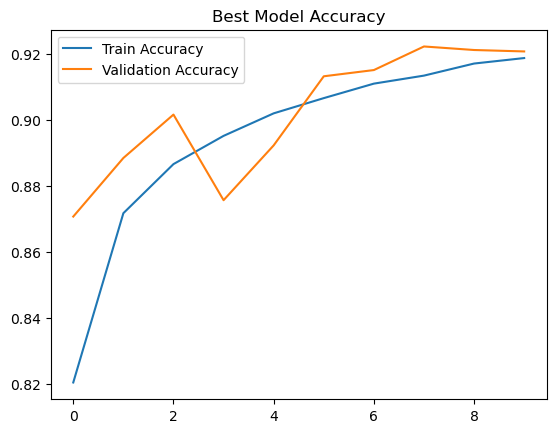

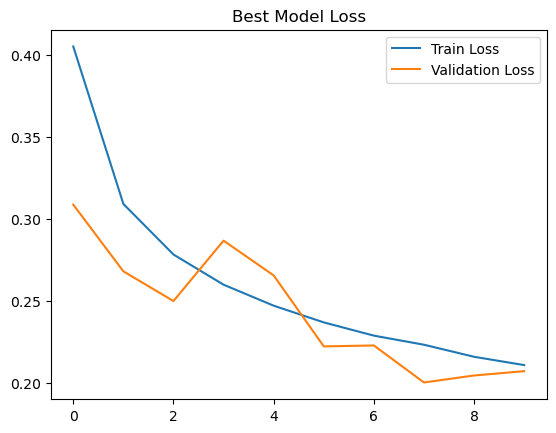

In [60]:
#plot training history for best_model
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Best Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Best Model Loss')
plt.show()

In [62]:
#evaluate on Test Set
test_predictions_best = best_model.predict(test_images)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step


In [63]:
submission_best = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(path))[0] for path in test_generator.filenames],
    'label': test_predictions_best.flatten()
})

submission_best_file_path = os.path.join(data_dir, 'submission_best.csv')
submission_best.to_csv(submission_best_file_path, index=False)
print(f"Submission file for best model saved to {submission_best_file_path}")


Submission file for best model saved to /Users/adrienne/Desktop/Week3_Cancer_Kaggle/submission_best.csv


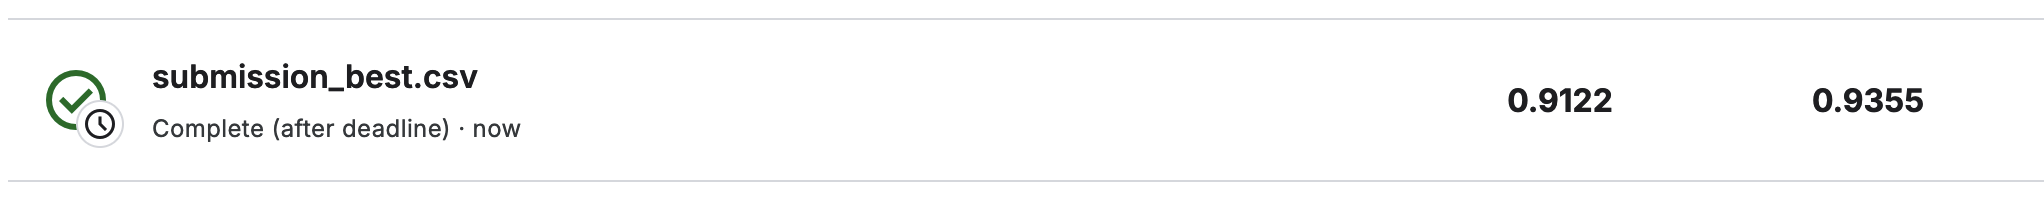

## Step 4: Results and Analysis

The hyperparameter tuning helped optimize the model. Because of time I was not able to run a full parameter search to optimize tuning, however even what we did apply was beneficial. Given more time I would suggest running a more in depth parameter search to increase the fit.

Comparing the two sets of plots it is clear that the "best model" has better alligment with between training and validatoin metrics, showing that it generalizes better. The validation curve better aligns with the training accuracy and there is less fluctuation. Furthermore, the validation loss is smoother and converges more closely with the training loss. The reflects a more stable training process and better performance on the validation set. 

The best model performed better on the test set as well (as shown below). it increased by a bit under 1% in the private score. This shows that using parameter tuning increases the accuracy. Again, it is worth mentioning that futher parameter tuning would be beneficial.

The parameter tuning showed that fewer filters in the convolutional layers increased performance. They may help mitigate overfitting.

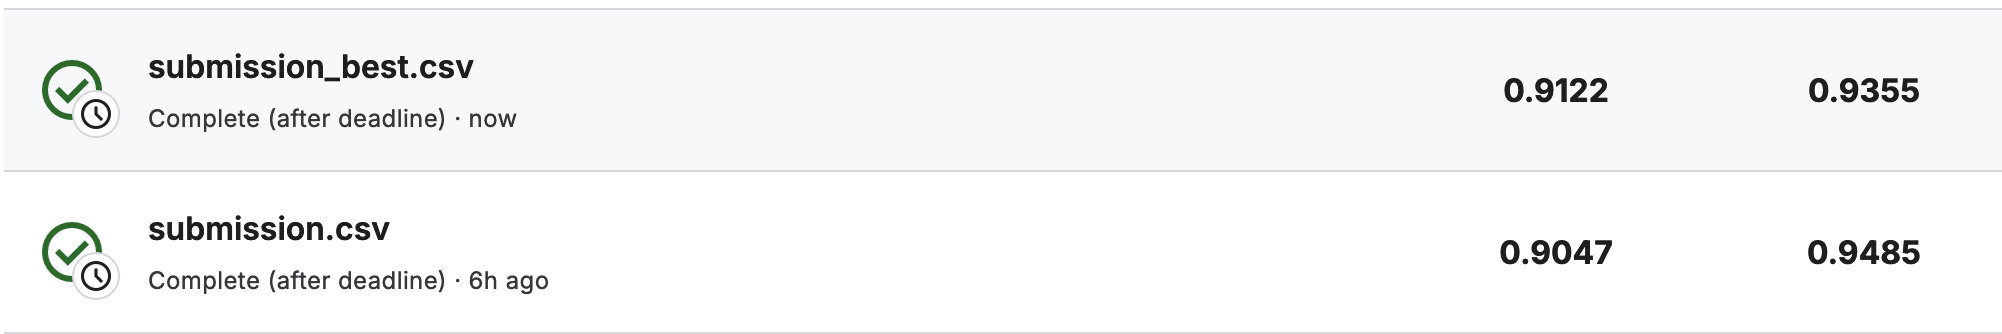

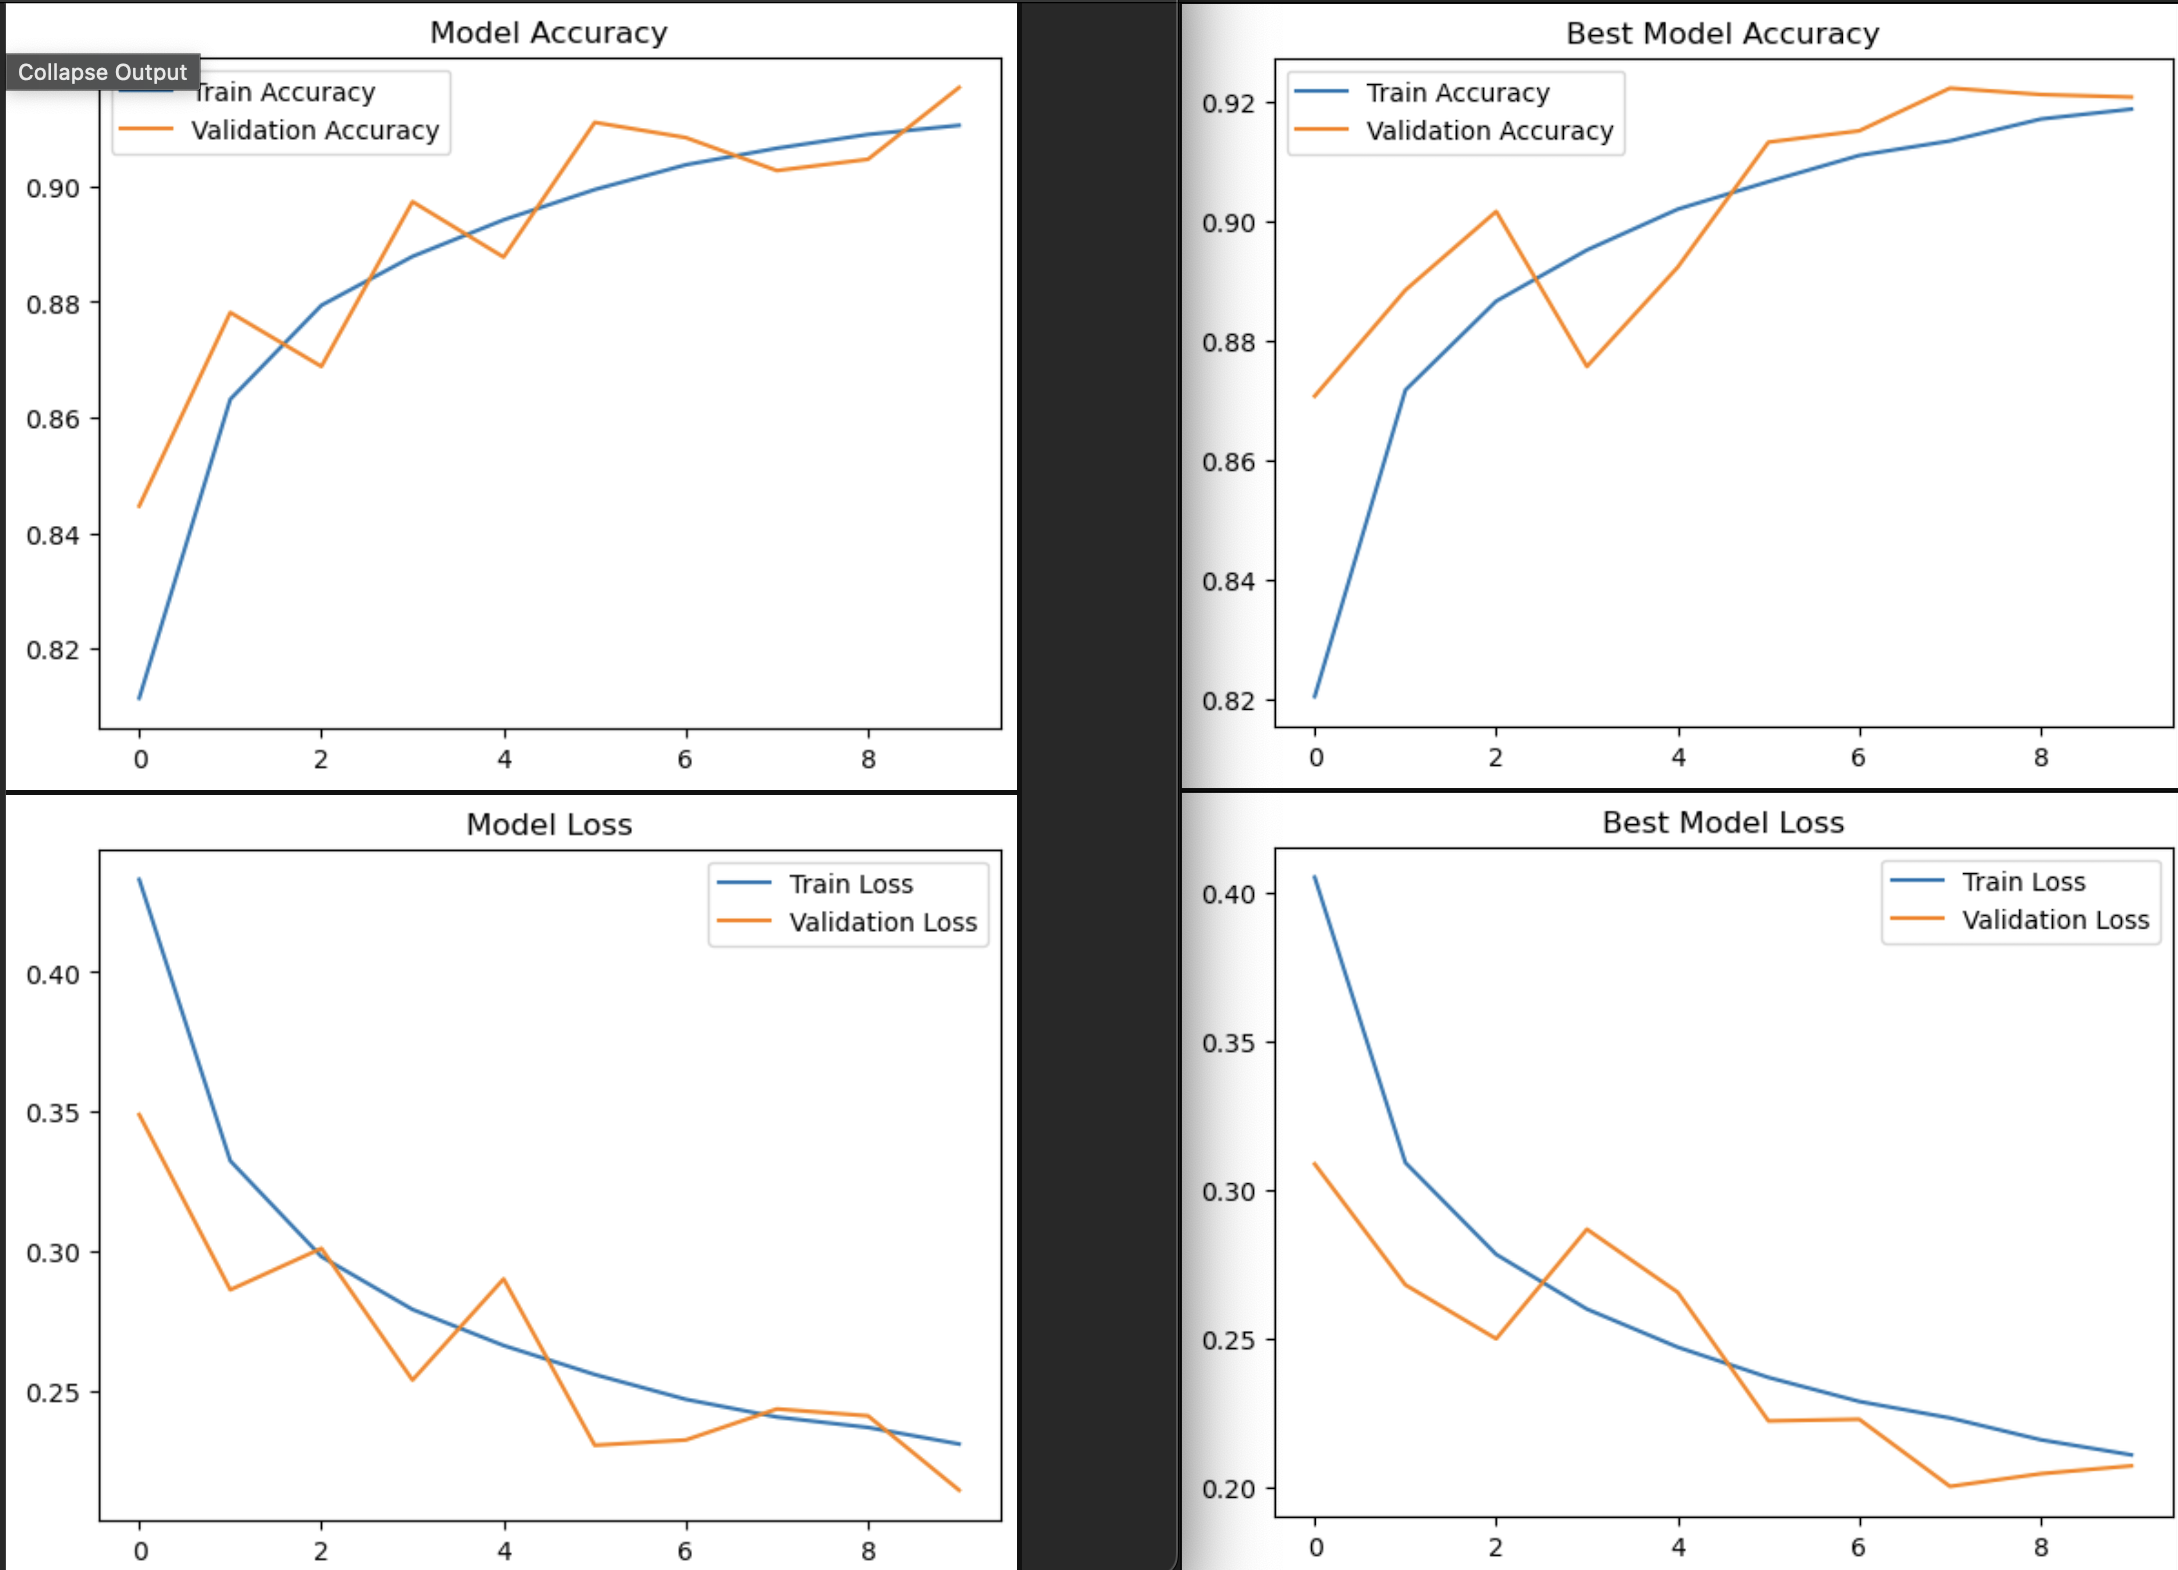